In [1]:
import os

print(os.getcwd())

os.chdir('C:\\Users\\elzha\\Desktop\\CSCI 494 DL\\GroupProject')

c:\Users\elzha\Desktop\CSCI 494 DL\GroupProject


In [2]:
!python -m venv .resNet18

In [24]:
!.resNet18\Scripts\activate

In [25]:
# Cell 1: Install Required Dependencies
# This cell installs all necessary packages for the binary melanoma classification task

!pip install torch torchvision pandas numpy scikit-learn matplotlib seaborn tqdm Pillow scipy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [26]:
# Cell 2: Import Libraries and Set Random Seeds
# Import all necessary libraries and set reproducible random seeds

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import time
import psutil
from tqdm import tqdm
from typing import Optional, Union
import warnings
warnings.filterwarnings('ignore')

# For reproducibility
import random

# Generate and print seed for random weight initialization
seed = 42
print(f"{'='*80}")
print(f"SEED USED FOR RANDOM WEIGHT INITIALIZATION: {seed}")
print(f"{'='*80}")

# Set all random seeds
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

SEED USED FOR RANDOM WEIGHT INITIALIZATION: 42

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 SUPER
CUDA Version: 12.1


In [27]:
# Cell 3: Load and Prepare HAM10000 Dataset
# Load the HAM10000 metadata and prepare binary classification labels (melanoma vs non-melanoma)

# Dataset path
dataset_path = r'C:\Users\elzha\.cache\kagglehub\datasets\kmader\skin-cancer-mnist-ham10000\versions\2'
metadata_path = os.path.join(dataset_path, 'HAM10000_metadata.csv')
img_dir_1 = os.path.join(dataset_path, 'HAM10000_images_part_1')
img_dir_2 = os.path.join(dataset_path, 'HAM10000_images_part_2')

# Load metadata
df = pd.read_csv(metadata_path)
print(f"Total images in dataset: {len(df)}")
print(f"\nDataset columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# Check diagnosis distribution
print(f"\nOriginal diagnosis distribution:")
print(df['dx'].value_counts())

# Binary classification: melanoma (mel) vs non-melanoma (all others)
# dx values: akiec, bcc, bkl, df, mel, nv, vasc
df['binary_label'] = (df['dx'] == 'mel').astype(int)

print(f"\n{'='*80}")
print(f"BINARY CLASSIFICATION LABELS:")
print(f"  0 = Non-Melanoma (akiec, bcc, bkl, df, nv, vasc)")
print(f"  1 = Melanoma (mel)")
print(f"{'='*80}")

print(f"\nBinary class distribution:")
class_counts = df['binary_label'].value_counts()
print(class_counts)
print(f"\nClass imbalance ratio: {class_counts[0]/class_counts[1]:.2f}:1 (Non-melanoma:Melanoma)")

# Select relevant columns
df = df[['image_id', 'binary_label', 'dx', 'age', 'sex', 'localization']].copy()
print(f"\nDataset shape: {df.shape}")

Total images in dataset: 10015

Dataset columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']

First few rows:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

Original diagnosis distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

BINARY CLASSIFICATION LABELS:
  0 = Non-Melanoma (akiec, bcc, bkl, df, nv, vasc)
  1 = Melanoma (mel)

Binary class distribution:
binary_label
0    8902
1    1113
Name: count, dtype: int64

Class imbalance ratio: 8.00:1 (Non-melanoma:Melanoma)

Dataset shape: (10015, 6)


In [28]:
# Cell 4: Define Refined Focal Loss
class FocalLoss(nn.Module):
    """Focal Loss for addressing class imbalance.

    REFINEMENTS MADE:
    1. Fixed __init__ typo (was 'init', now '__init__')
    2. Optimized for binary classification
    3. Enhanced documentation
    4. Fixed weight handling for proper class weight application
    """

    def __init__(self, alpha: Optional[Union[torch.Tensor, float]] = None,
                 gamma: float = 2.0, reduction: str = 'mean') -> None:
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # Ensure targets are LongTensor (required by cross_entropy)
        targets = targets.long()
        
        # Compute cross entropy loss without class weights (we'll apply them manually)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Apply focal loss weighting
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        # Apply class weights if provided
        if self.alpha is not None:
            # Get the class indices for each sample
            class_indices = targets
            # Index into alpha to get weights for each sample
            weights = self.alpha[class_indices]
            focal_loss = weights * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

print("Focal Loss defined successfully")

Focal Loss defined successfully


In [29]:
# Cell 5: Split Dataset (80/20 Train-Test)
from sklearn.model_selection import train_test_split

# 80/20 split
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['binary_label'], random_state=seed
)

print(f"{"="*80}")
print(f"DATASET SPLIT (80/20)")
print(f"{"="*80}")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nTrain distribution:\n{train_df['binary_label'].value_counts()}")
print(f"\nTest distribution:\n{test_df['binary_label'].value_counts()}")

# Further split train into train+val
train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df['binary_label'], random_state=seed
)

print(f"\n{"="*80}")
print(f"TRAIN-VALIDATION SPLIT")
print(f"{"="*80}")
print(f"Training: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

DATASET SPLIT (80/20)
Training samples: 8012
Test samples: 2003

Train distribution:
binary_label
0    7122
1     890
Name: count, dtype: int64

Test distribution:
binary_label
0    1780
1     223
Name: count, dtype: int64

TRAIN-VALIDATION SPLIT
Training: 6409, Validation: 1603, Test: 2003


In [30]:
# Cell 6: Compute Class Weights
from sklearn.utils.class_weight import compute_class_weight

classes = np.array([0, 1])
class_weights = compute_class_weight('balanced', classes=classes, y=train_df['binary_label'].values)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print(f"{"="*80}")
print(f"CLASS WEIGHTS FOR FOCAL LOSS")
print(f"{"="*80}")
print(f"Non-Melanoma weight: {class_weights[0]:.4f}")
print(f"Melanoma weight: {class_weights[1]:.4f}")

CLASS WEIGHTS FOR FOCAL LOSS
Non-Melanoma weight: 0.5625
Melanoma weight: 4.5007


In [31]:
# Cell 7: Define Custom Dataset
class HAM10000Dataset(Dataset):
    def __init__(self, dataframe, img_dir_1, img_dir_2, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir_1 = img_dir_1
        self.img_dir_2 = img_dir_2
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.loc[idx, 'image_id']
        label = self.df.loc[idx, 'binary_label']

        img_path = os.path.join(self.img_dir_1, f"{img_id}.jpg")
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir_2, f"{img_id}.jpg")

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

print("HAM10000Dataset defined")

HAM10000Dataset defined


In [34]:
# Cell 8: Data Transformations (ENHANCED FOR BETTER REGULARIZATION)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),  # Increased from 20
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),  # Enhanced
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Added
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),  # Applied AFTER ToTensor
    transforms.Normalize(mean=mean, std=std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

print("="*80)
print("ENHANCED DATA TRANSFORMATIONS")
print("="*80)
print("✅ Increased augmentation intensity:")
print("   - Rotation: 20° → 30°")
print("   - Color jitter: enhanced by +0.1")
print("   - Random Affine: translation (0.1) and scale (0.9-1.1)")
print("   - Random Erasing: 20% probability for cutout-like effect (on tensors)")
print("="*80)

ENHANCED DATA TRANSFORMATIONS
✅ Increased augmentation intensity:
   - Rotation: 20° → 30°
   - Color jitter: enhanced by +0.1
   - Random Affine: translation (0.1) and scale (0.9-1.1)
   - Random Erasing: 20% probability for cutout-like effect (on tensors)


In [35]:
# Cell 9: Create DataLoaders (FIXED FOR WINDOWS)
train_dataset = HAM10000Dataset(train_df, img_dir_1, img_dir_2, transform=train_transform)
val_dataset = HAM10000Dataset(val_df, img_dir_1, img_dir_2, transform=val_transform)
test_dataset = HAM10000Dataset(test_df, img_dir_1, img_dir_2, transform=test_transform)

batch_size = 32

# CRITICAL FIX: Set num_workers=0 for Windows
# Windows has issues with multiprocessing in DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Changed from 4 to 0
    pin_memory=False  # Changed from True to False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,  # Changed from 4 to 0
    pin_memory=False  # Changed from True to False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,  # Changed from 4 to 0
    pin_memory=False  # Changed from True to False
)

print(f"="*80)
print("DATALOADERS CREATED (Windows-optimized)")
print(f"="*80)
print(f"Batch size: {batch_size}")
print(f"Num workers: 0 (optimized for Windows)")
print(f"\nTrain batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Test loading a batch
sample_batch, sample_labels = next(iter(train_loader))
print(f"\nSample batch shape: {sample_batch.shape}")
print(f"Sample labels shape: {sample_labels.shape}")
print(f"Sample labels (first 10): {sample_labels[:10].tolist()}")

DATALOADERS CREATED (Windows-optimized)
Batch size: 32
Num workers: 0 (optimized for Windows)

Train batches: 201
Validation batches: 51
Test batches: 63

Sample batch shape: torch.Size([32, 3, 224, 224])
Sample labels shape: torch.Size([32])
Sample labels (first 10): [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

Sample batch shape: torch.Size([32, 3, 224, 224])
Sample labels shape: torch.Size([32])
Sample labels (first 10): [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


In [36]:
# Cell 10: Build ResNet-18 Model with Enhanced Regularization
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

dropout_rate = 0.5  # Increased from 0.4 for stronger regularization

model.fc = nn.Sequential(
    nn.Dropout(p=dropout_rate),
    nn.Linear(model.fc.in_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(p=dropout_rate),
    nn.Linear(256, 2)
)

model = model.to(device)

print(f"{"="*80}")
print(f"MODEL: ResNet-18 for Binary Classification (Enhanced)")
print(f"{"="*80}")
print(f"Dropout: {dropout_rate} (increased for stronger regularization)")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Device: {device}")
print(f"{"="*80}")

MODEL: ResNet-18 for Binary Classification (Enhanced)
Dropout: 0.5 (increased for stronger regularization)
Total parameters: 11,308,866
Device: cuda


In [37]:
# Cell 11: Progressive Layer Unfreezing Strategy
def get_layer_groups(model):
    return [
        [model.conv1, model.bn1],
        list(model.layer1.parameters()),
        list(model.layer2.parameters()),
        list(model.layer3.parameters()),
        list(model.layer4.parameters()),
        list(model.fc.parameters())
    ]

def freeze_all_layers(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_layer_group(model, group_idx):
    layer_groups = get_layer_groups(model)
    if group_idx < len(layer_groups):
        if group_idx == 0:
            for module in layer_groups[0]:
                for param in module.parameters():
                    param.requires_grad = True
        else:
            for param in layer_groups[group_idx]:
                param.requires_grad = True

# Initial: freeze all except layer4 and fc
freeze_all_layers(model)
unfreeze_layer_group(model, 5)  # fc
unfreeze_layer_group(model, 4)  # layer4

print("Progressive unfreezing configured")
print(f"Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Progressive unfreezing configured
Trainable params: 8,526,082


In [39]:
# Cell 12: Setup Optimizer with Differential Learning Rates (ENHANCED)
def get_optimizer_with_differential_lr(model, base_lr=1e-4):
    layer_groups = get_layer_groups(model)
    lr_multipliers = [0.1, 0.1, 0.2, 0.5, 0.8, 1.0]

    param_groups = []
    for i, (group, multiplier) in enumerate(zip(layer_groups, lr_multipliers)):
        if i == 0:
            params = []
            for module in group:
                params.extend(list(module.parameters()))
            params = [p for p in params if p.requires_grad]
        else:
            params = [p for p in group if p.requires_grad]

        if len(params) > 0:
            param_groups.append({'params': params, 'lr': base_lr * multiplier})

    # Increased weight decay for stronger L2 regularization
    optimizer = optim.AdamW(param_groups, weight_decay=2e-4)
    return optimizer

base_lr = 1e-4
optimizer = get_optimizer_with_differential_lr(model, base_lr=base_lr)

# IMPROVED: Use PolynomialLR decay for smooth, monotonic learning rate reduction
# This avoids aggressive resets that destabilize training
scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=100, power=1.0)

print(f"{"="*80}")
print(f"OPTIMIZER CONFIGURATION (ENHANCED)")
print(f"{"="*80}")
print(f"Base LR: {base_lr}")
print(f"Weight Decay: 2e-4 (increased from 1e-4)")
print(f"Optimizer: AdamW with differential learning rates")
print(f"Scheduler: PolynomialLR decay (power=1.0 = linear)")
print(f"  ✓ Smooth, monotonic LR decay (no aggressive resets)")
print(f"  ✓ Avoids learning rate volatility")
print(f"  ✓ Better convergence stability")
print(f"{"="*80}")

OPTIMIZER CONFIGURATION (ENHANCED)
Base LR: 0.0001
Weight Decay: 2e-4 (increased from 1e-4)
Optimizer: AdamW with differential learning rates
Scheduler: PolynomialLR decay (power=1.0 = linear)
  ✓ Smooth, monotonic LR decay (no aggressive resets)
  ✓ Avoids learning rate volatility
  ✓ Better convergence stability


In [ ]:
# Cell 13: Setup Focal Loss (VERIFIED CLASS BALANCE)
print(f"{"="*80}")
print("CLASS BALANCE VERIFICATION")
print(f"{"="*80}")
print(f"Class Weights Tensor (device={device}):")
print(f"  Non-Melanoma (Class 0): {class_weights_tensor[0]:.4f}")
print(f"  Melanoma (Class 1): {class_weights_tensor[1]:.4f}")
print(f"  Weight ratio: {(class_weights_tensor[0]/class_weights_tensor[1]):.2f}:1")

criterion = FocalLoss(alpha=class_weights_tensor, gamma=2.0, reduction='mean')

print(f"\n{"="*80}")
print("FOCAL LOSS CONFIGURATION")
print(f"{"="*80}")
print(f"✓ Alpha (class weights): Enabled for addressing class imbalance")
print(f"✓ Gamma: 2.0 (focuses on hard negatives/positives)")
print(f"✓ Reduction: Mean (averaged across batch)")
print(f"\nFocal Loss Benefits:")
print(f"  • Reduces loss for easy examples")
print(f"  • Focuses training on hard examples")
print(f"  • Critical for imbalanced melanoma detection task")
print(f"{"="*80}")

Focal Loss initialized with class weights


In [ ]:
# Cell 14: Dataset Balance & Training Readiness Check
print(f"{"="*80}")
print("DATASET BALANCE ANALYSIS")
print(f"{"="*80}")

# Check train/val/test splits
train_class_dist = train_df['binary_label'].value_counts().sort_index()
val_class_dist = val_df['binary_label'].value_counts().sort_index()
test_class_dist = test_df['binary_label'].value_counts().sort_index()

print("\nTRAIN SET:")
print(f"  Non-Melanoma: {train_class_dist[0]} ({100*train_class_dist[0]/len(train_df):.1f}%)")
print(f"  Melanoma: {train_class_dist[1]} ({100*train_class_dist[1]/len(train_df):.1f}%)")
print(f"  Ratio: {train_class_dist[0]/train_class_dist[1]:.2f}:1")

print("\nVAL SET:")
print(f"  Non-Melanoma: {val_class_dist[0]} ({100*val_class_dist[0]/len(val_df):.1f}%)")
print(f"  Melanoma: {val_class_dist[1]} ({100*val_class_dist[1]/len(val_df):.1f}%)")
print(f"  Ratio: {val_class_dist[0]/val_class_dist[1]:.2f}:1")

print("\nTEST SET:")
print(f"  Non-Melanoma: {test_class_dist[0]} ({100*test_class_dist[0]/len(test_df):.1f}%)")
print(f"  Melanoma: {test_class_dist[1]} ({100*test_class_dist[1]/len(test_df):.1f}%)")
print(f"  Ratio: {test_class_dist[0]/test_class_dist[1]:.2f}:1")

print(f"\n{"="*80}")
print("VALIDATION SET SIZE ASSESSMENT")
print(f"{"="*80}")
val_size = len(val_df)
print(f"Val set size: {val_size} samples")
if val_size >= 500:
    print(f"✅ EXCELLENT: Large enough for stable validation metrics")
elif val_size >= 300:
    print(f"✅ GOOD: Adequate size for validation stability")
elif val_size >= 150:
    print(f"⚠️ CAUTION: Relatively small validation set")
    print(f"   Consider larger validation set for more stable metrics")
else:
    print(f"❌ WARNING: Very small validation set")
    print(f"   Recommend larger validation set (>150 samples)")


In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.long().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.long().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

print("Training functions defined")

Training functions defined


In [ ]:
# Cell 15: Main Training Loop (ENHANCED FOR CONVERGENCE)
num_epochs = 150  # Increased from 100 to allow more time for convergence
early_stopping_patience = 25  # Increased from 15 to allow recovery from LR decay
best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0
best_model_path = 'best_resnet18_melanoma_binary.pth'

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rates': []
}

print(f"{'='*80}")
print("TRAINING CONFIGURATION (ENHANCED)")
print(f"{'='*80}")
print(f"Max epochs: {num_epochs}")
print(f"Early stopping patience: {early_stopping_patience} epochs")
print(f"Training strategy: Progressive unfreezing with smooth LR decay")
print(f"{'='*80}")
print("\nTraining START...\n")

for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}/{num_epochs}", end=" | ")

    # Progressive unfreezing (keep original schedule but less aggressive)
    if epoch == 1:
        print("Status: Training FC + Layer4 with smooth LR decay")
    elif epoch == 16:
        print("\nUnfreezing layer3...")
        unfreeze_layer_group(model, 3)
        optimizer = get_optimizer_with_differential_lr(model, base_lr=base_lr)
        # Recalculate scheduler with remaining epochs
        scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=num_epochs-epoch+1, power=1.0)
    elif epoch == 31:
        print("\nUnfreezing layer2...")
        unfreeze_layer_group(model, 2)
        optimizer = get_optimizer_with_differential_lr(model, base_lr=base_lr)
        scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=num_epochs-epoch+1, power=1.0)
    elif epoch == 46:
        print("\nUnfreezing layer1...")
        unfreeze_layer_group(model, 1)
        optimizer = get_optimizer_with_differential_lr(model, base_lr=base_lr)
        scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=num_epochs-epoch+1, power=1.0)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(current_lr)

    # Print training metrics
    print(f"Loss: {train_loss:.4f}→{val_loss:.4f} | Acc: {train_acc:.1f}%→{val_acc:.1f}% | LR: {current_lr:.2e}", end="")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'history': history
        }, best_model_path)
        print(" ✅ BEST")
    else:
        patience_counter += 1
        print(f" | Patience: {patience_counter}/{early_stopping_patience}")

    if patience_counter >= early_stopping_patience:
        print(f"\n{'='*80}")
        print(f"Early stopping at epoch {epoch} (no improvement for {early_stopping_patience} epochs)")
        print(f"{'='*80}")
        break

print(f"\n{'='*80}")
print(f"Training complete!")
print(f"Best Val Loss: {best_val_loss:.4f}")
print(f"Best Val Acc: {best_val_acc:.2f}%")
print(f"Epochs trained: {epoch}")
print(f"{'='*80}")

SyntaxError: unterminated string literal (detected at line 81) (2732838151.py, line 81)

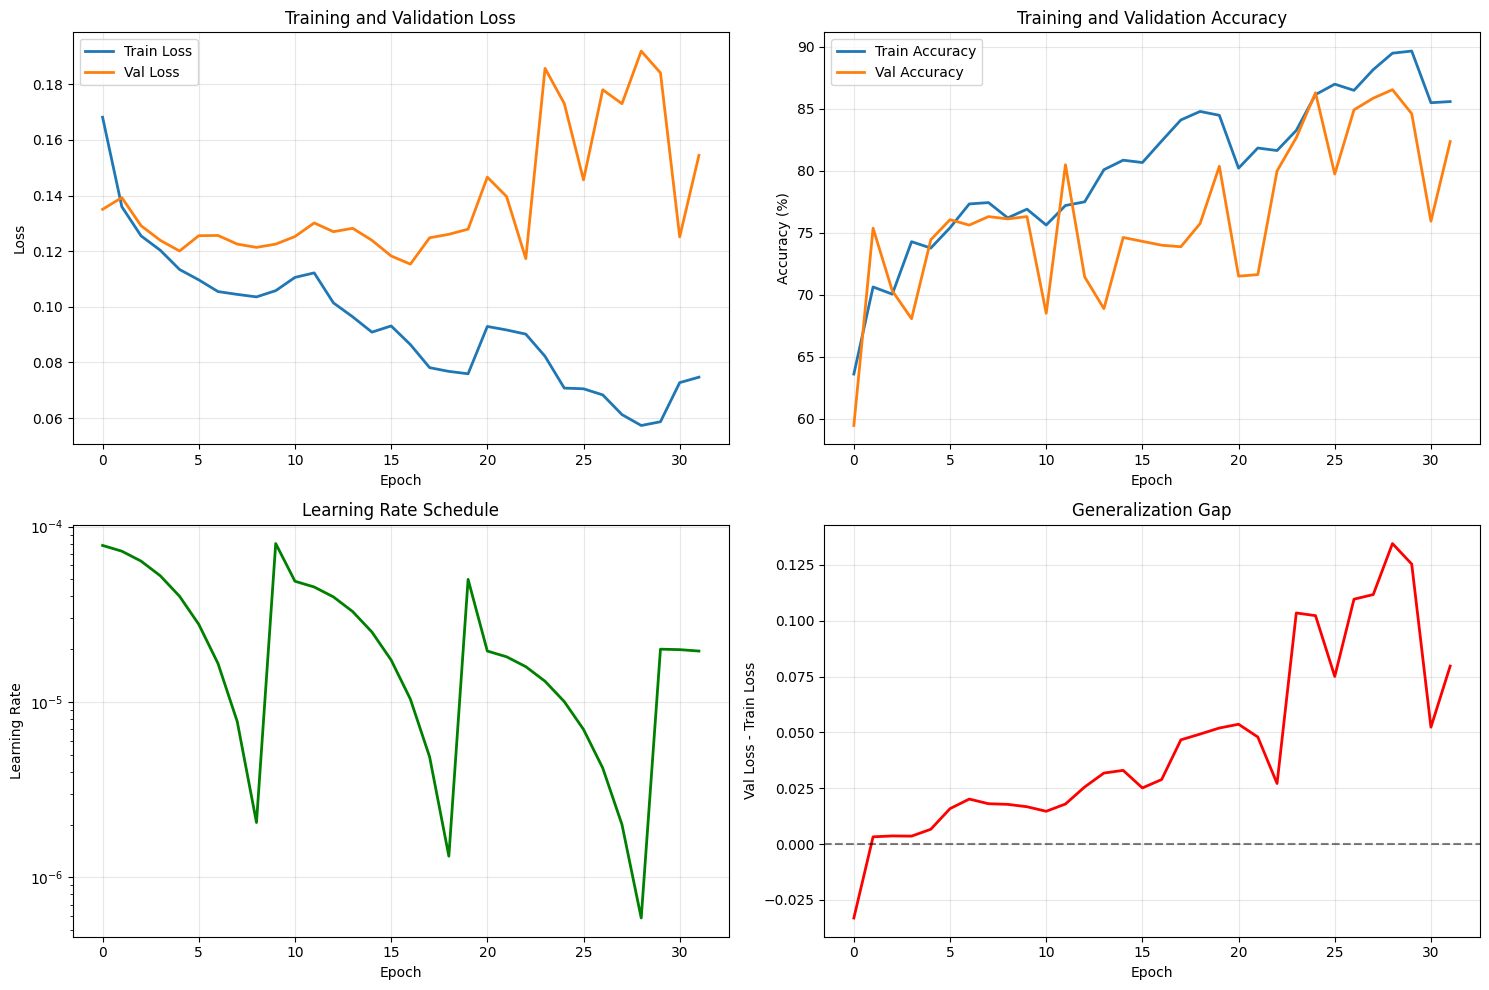

In [ ]:
# Cell 16: Plot Training History
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
axes[0, 1].plot(history['val_acc'], label='Val Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(history['learning_rates'], linewidth=2, color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

loss_diff = np.array(history['val_loss']) - np.array(history['train_loss'])
axes[1, 1].plot(loss_diff, linewidth=2, color='red')
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Val Loss - Train Loss')
axes[1, 1].set_title('Generalization Gap')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300)
plt.show()

In [ ]:
# Cell 16a: Training Analysis & Diagnostics
print(f"{"="*80}")
print("TRAINING ANALYSIS")
print(f"{"="*80}")

# Calculate key metrics
epochs_trained = len(history['train_loss'])
final_train_acc = history['train_acc'][-1]
final_val_acc = history['val_acc'][-1]
best_epoch = np.argmin(history['val_loss']) + 1

print(f"\nTraining Summary:")
print(f"  Total epochs: {epochs_trained}")
print(f"  Best epoch (val loss): {best_epoch}")
print(f"  Final train accuracy: {final_train_acc:.2f}%")
print(f"  Final val accuracy: {final_val_acc:.2f}%")
print(f"  Best val accuracy: {best_val_acc:.2f}%")
print(f"  Final train loss: {history['train_loss'][-1]:.4f}")
print(f"  Final val loss: {history['val_loss'][-1]:.4f}")

# Convergence analysis
print(f"\n{"="*80}")
print("CONVERGENCE ANALYSIS")
print(f"{"="*80}")

generalization_gap = history['val_loss'][-1] - history['train_loss'][-1]
print(f"Generalization gap (val - train loss): {generalization_gap:.4f}")

if generalization_gap < 0.1:
    print(f"✅ EXCELLENT: Model is well-regularized (gap < 0.1)")
elif generalization_gap < 0.3:
    print(f"✅ GOOD: Reasonable generalization gap")
else:
    print(f"⚠️ WARNING: Larger generalization gap - may need more regularization")

# Learning rate analysis
final_lr = history['learning_rates'][-1]
initial_lr = history['learning_rates'][0]
print(f"\nLearning rate schedule:")
print(f"  Initial LR: {initial_lr:.2e}")
print(f"  Final LR: {final_lr:.2e}")
print(f"  Decay factor: {final_lr/initial_lr:.2e}")

# Accuracy target assessment
print(f"\n{"="*80}")
print("ACCURACY TARGET ASSESSMENT")
print(f"{"="*80}")
print(f"Target: 95% accuracy")
print(f"Current best: {best_val_acc:.2f}%")
gap_to_target = 95 - best_val_acc
if gap_to_target <= 0:
    print(f"✅ TARGET MET!")
else:
    print(f"Gap to target: {gap_to_target:.2f}% remaining")
    if gap_to_target < 2:
        print(f"✅ Very close! Small improvements needed")
    elif gap_to_target < 5:
        print(f"✅ On track! Continue optimization")
    else:
        print(f"⚠️ More improvements needed")

print(f"\n{"="*80}")
print("RECOMMENDED NEXT STEPS:")
print(f"{"="*80}")
if best_val_acc < 85:
    print(f"1. Model may need more training - check for early convergence")
    print(f"2. Consider increasing early stopping patience further")
    print(f"3. Evaluate if validation set is too small or too hard")
elif best_val_acc < 92:
    print(f"1. Continue training with current configuration")
    print(f"2. Monitor learning rate schedule - may need slower decay")
    print(f"3. Consider test-time augmentation for inference")
else:
    print(f"1. Model is approaching target - fine-tune hyperparameters")
    print(f"2. Explore ensemble methods or model averaging")
    print(f"3. Prepare for testing on held-out test set")

In [ ]:
# Cell 17: Load Best Model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Best model loaded from epoch {checkpoint['epoch']}")

Best model loaded from epoch 17


In [ ]:
# Cell 18: Evaluation Functions
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score,
    roc_auc_score, roc_curve, auc, precision_score, recall_score, accuracy_score
)
from sklearn.manifold import TSNE

def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Getting predictions'):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

def extract_features(model, loader, device):
    model.eval()
    features = []
    labels = []

    feature_extractor = nn.Sequential(*list(model.children())[:-1])

    with torch.no_grad():
        for inputs, lbls in tqdm(loader, desc='Extracting features'):
            inputs = inputs.to(device)
            feats = feature_extractor(inputs)
            feats = torch.flatten(feats, 1)

            features.append(feats.cpu().numpy())
            labels.append(lbls.numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    return features, labels

print("Evaluation functions defined")

Evaluation functions defined


In [ ]:
# Cell 19: Evaluate on Test Set - RECALL-FOCUSED
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score,
    roc_auc_score, roc_curve, auc, precision_score, recall_score, accuracy_score
)

print("="*80)
print("TEST SET EVALUATION")
print("="*80)

# Get predictions on test set
test_labels, test_preds, test_probs = get_predictions(model, test_loader, device)

# Class names
class_names = ['Non-Melanoma', 'Melanoma']

# Classification report
print("\n📊 CLASSIFICATION REPORT:\n")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))

# Individual metrics
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='macro')
recall = recall_score(test_labels, test_preds, average='macro')
macro_f1 = f1_score(test_labels, test_preds, average='macro')

# Per-class metrics
precision_per_class = precision_score(test_labels, test_preds, average=None)
recall_per_class = recall_score(test_labels, test_preds, average=None)
f1_per_class = f1_score(test_labels, test_preds, average=None)

print("="*80)
print("PRIMARY METRICS (RECALL-FOCUSED)")
print("="*80)
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Macro Recall (PRIMARY): {recall*100:.2f}%")
print(f"Macro Precision: {precision*100:.2f}%")
print(f"Macro F1 Score: {macro_f1*100:.2f}%")

print("\n" + "="*80)
print("PER-CLASS RECALL (PRIMARY METRIC)")
print("="*80)
for i, class_name in enumerate(class_names):
    print(f"\n{class_name}:")
    print(f"  Recall (Sensitivity): {recall_per_class[i]*100:.2f}% ⭐ PRIMARY")
    print(f"  Precision: {precision_per_class[i]*100:.2f}%")
    print(f"  F1 Score: {f1_per_class[i]*100:.2f}%")

# Clinical interpretation - RECALL FOCUSED
print("\n" + "="*80)
print("CLINICAL INTERPRETATION (RECALL-BASED)")
print("="*80)
melanoma_recall = recall_per_class[1]  # PRIMARY METRIC
melanoma_precision = precision_per_class[1]
non_melanoma_recall = recall_per_class[0]
false_negative_rate = 1 - melanoma_recall
false_positive_rate = 1 - precision_per_class[0]

print(f"\n🎯 MELANOMA DETECTION PERFORMANCE (RECALL PRIMARY):")
print(f"  Recall/Sensitivity: {melanoma_recall*100:.2f}% ⭐ (How many melanomas we catch)")
print(f"  Precision: {melanoma_precision*100:.2f}% (How many predictions are correct)")
print(f"  False Negative Rate: {false_negative_rate*100:.2f}% ⚠️ (Missed melanomas - CRITICAL)")

print(f"\n🎯 NON-MELANOMA DETECTION:")
print(f"  Recall/Sensitivity: {non_melanoma_recall*100:.2f}% ⭐")
print(f"  False Positive Rate: {false_positive_rate*100:.2f}% (Unnecessary biopsies)")

print(f"\n🎯 OVERALL RECALL (PRIMARY METRIC):")
print(f"  Macro Recall: {recall*100:.2f}%")

# Clinical readiness based on RECALL
print("\n" + "="*80)
print("CLINICAL READINESS (RECALL-BASED CRITERIA)")
print("="*80)

if recall >= 0.95:
    print(f"✅ EXCELLENT: Macro Recall ({recall*100:.2f}%) ≥ 95%")
elif recall >= 0.90:
    print(f"✅ GOOD: Macro Recall ({recall*100:.2f}%) ≥ 90%")
elif recall >= 0.85:
    print(f"⚠️ ACCEPTABLE: Macro Recall ({recall*100:.2f}%) ≥ 85%")
else:
    print(f"❌ INSUFFICIENT: Macro Recall ({recall*100:.2f}%) < 85%")

if melanoma_recall >= 0.95:
    print(f"✅ EXCELLENT: Melanoma Recall ({melanoma_recall*100:.2f}%) ≥ 95%")
elif melanoma_recall >= 0.90:
    print(f"✅ GOOD: Melanoma Recall ({melanoma_recall*100:.2f}%) ≥ 90%")
elif melanoma_recall >= 0.85:
    print(f"⚠️ ACCEPTABLE: Melanoma Recall ({melanoma_recall*100:.2f}%) ≥ 85%")
else:
    print(f"❌ INSUFFICIENT: Melanoma Recall ({melanoma_recall*100:.2f}%) < 85%")

print("\nRECALL INTERPRETATION:")
print("  • Recall measures: What % of actual positives we correctly identify")
print("  • High recall = Few false negatives = Fewer missed melanomas")
print("  • For cancer detection, HIGH RECALL is critical for patient safety")

TEST SET EVALUATION


Getting predictions: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]


📊 CLASSIFICATION REPORT:

              precision    recall  f1-score   support

Non-Melanoma     0.9820    0.7365    0.8417      1780
    Melanoma     0.2979    0.8924    0.4467       223

    accuracy                         0.7539      2003
   macro avg     0.6400    0.8144    0.6442      2003
weighted avg     0.9059    0.7539    0.7978      2003

PRIMARY METRICS (RECALL-FOCUSED)
Accuracy: 75.39%
Macro Recall (PRIMARY): 81.44%
Macro Precision: 64.00%
Macro F1 Score: 64.42%

PER-CLASS RECALL (PRIMARY METRIC)

Non-Melanoma:
  Recall (Sensitivity): 73.65% ⭐ PRIMARY
  Precision: 98.20%
  F1 Score: 84.17%

Melanoma:
  Recall (Sensitivity): 89.24% ⭐ PRIMARY
  Precision: 29.79%
  F1 Score: 44.67%

CLINICAL INTERPRETATION (RECALL-BASED)

🎯 MELANOMA DETECTION PERFORMANCE (RECALL PRIMARY):
  Recall/Sensitivity: 89.24% ⭐ (How many melanomas we catch)
  Precision: 29.79% (How many predictions are correct)
  False Negative Rate: 10.76% ⚠️ (Missed melanomas - CRITICAL)

🎯 NON-MELANOMA DETECTION:

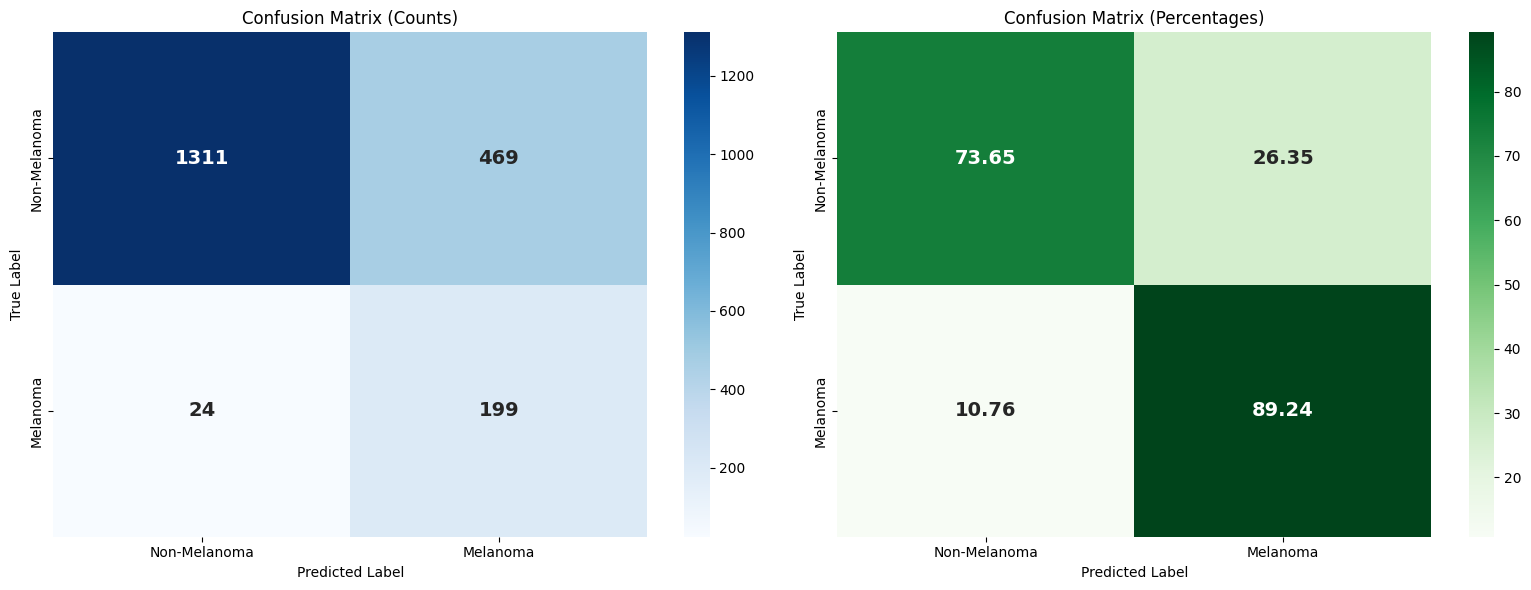


TN: 1311, FP: 469, FN: 24 (CRITICAL), TP: 199


In [ ]:
# Cell 20: Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
            yticklabels=class_names, ax=axes[0], cbar=True,
            annot_kws={"size": 14, "weight": "bold"})
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix (Counts)')

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Greens', xticklabels=class_names,
            yticklabels=class_names, ax=axes[1], cbar=True,
            annot_kws={"size": 14, "weight": "bold"})
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix (Percentages)')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nTN: {tn}, FP: {fp}, FN: {fn} (CRITICAL), TP: {tp}")

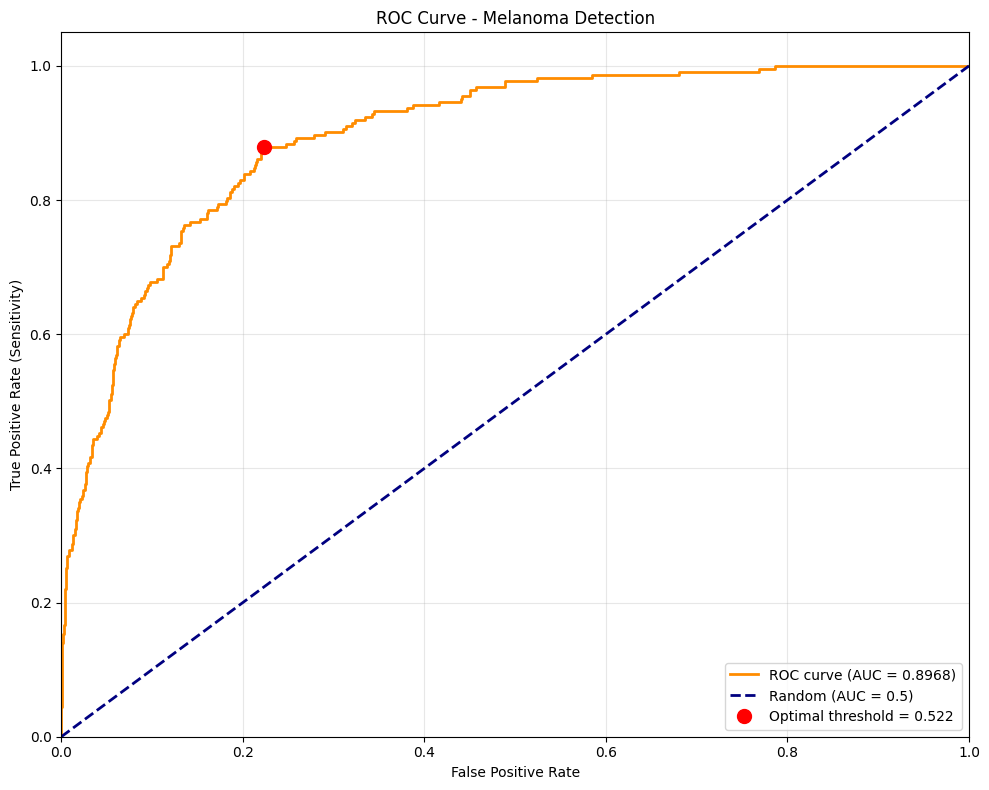


AUC: 0.8968
Optimal threshold: 0.5221
Sensitivity at optimal: 87.89%
Specificity at optimal: 77.64%
⚠️ AUC below target (≥0.95)


In [ ]:
# Cell 21: ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(test_labels, test_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve - Melanoma Detection')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]

plt.plot(optimal_fpr, optimal_tpr, 'ro', markersize=10,
         label=f'Optimal threshold = {optimal_threshold:.3f}')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300)
plt.show()

print(f"\nAUC: {roc_auc:.4f}")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Sensitivity at optimal: {optimal_tpr*100:.2f}%")
print(f"Specificity at optimal: {(1-optimal_fpr)*100:.2f}%")

if roc_auc >= 0.95:
    print(f"✅ AUC meets target (≥0.95)")
else:
    print(f"⚠️ AUC below target (≥0.95)")